In [16]:
from utils import *
from SMT import SMT, SMT_SGD, W_decompose
from Model_gpu import ProtoRNN

from itertools import combinations
from itertools import chain as ch
from tqdm import tqdm, trange

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from numpy.linalg import norm
from scipy.stats import sem, pearsonr
import scipy.stats as stats
import scipy.linalg as linalg
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
import pandas as pd
import joblib
import re

import torch
import torchvision.datasets as ds
import torchvision.transforms.functional as ttf
from einops import rearrange, repeat

In [17]:
SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')
device

device(type='cpu')

In [4]:
# image param
num_kernel = 64
num_row = 8
num_col = 8

# simulation param
tau_stim = 150
delta_t = 1 
save_every_stim = 15

# init model
f = ProtoRNN(num_kernel, num_row, num_col, tau_stim, delta_t, save_every_stim)

# set wrp and theta [Optional]
# wrp = np.load(r'E:\Dataset\Lee\Circuits_noise_v3//weight_epoch4_tx25_100ms_20_10x10_64_8_8_mix50%_v3.npy')
# f.wrp = wrp

# move to deivice
f.to(device)

ProtoRNN()

### Circuit - Image SMT

#### Ver2-nl

In [5]:
postfix = {0: 'clear', 1: '10%', 2: '30%', 3: '50%'}
num_imgs = 5

mix_coef = 2
r_in = np.load('E:/Dataset/Lee/SMT-BCM_input_correct/r_in_cifar_all_noise_abs_5_4_10_64_8_8.npy')
r_in, t_ind, n_ind = insertTeachingSig(r_in, p=mix_coef)

**Eigenspectra**

In [6]:
def get_eigspec(num_modes, epoch, img, nl):
    # image specific eigenspectra
    eigd = joblib.load(f'SMT-BCM_Jac_v3/epoch{epoch}/edc_jac_img{img}_{postfix[nl]}_sample.pkl')
    eigspec = eigd['val']
    vl = eigd['vl']
    vl_prime = eigd['vl_prime']

    # slowest decaying mode
    mode_s = vl[:, :num_modes]  # Ne+Ni, 20
    # mode_s = mode_s / norm(mode_s, axis=0, keepdims=True)
    # change of variable modes
    mode_s_prime = vl_prime[:, :num_modes]  # Ne+Ni, 20
    # mode_s_prime = mode_s_prime / norm(mode_s_prime, axis=0, keepdims=True)
    
    return eigspec, mode_s, mode_s_prime


def get_eigspec_pre(num_modes, img, nl):
    # image specific eigenspectra
    eigd = joblib.load(f'SMT-BCM_Jac_v3/pre/edc_jac_img{img}_{postfix[nl]}_sample.pkl')
    eigspec = eigd['val']
    vl = eigd['vl']
    vl_prime = eigd['vl_prime']

    # slowest decaying mode
    mode_s = vl[:, :num_modes]  # Ne+Ni, 20
    # mode_s = mode_s / norm(mode_s, axis=0, keepdims=True)
    # change of variable modes
    mode_s_prime = vl_prime[:, :num_modes]  # Ne+Ni, 20
    # mode_s_prime = mode_s_prime / norm(mode_s_prime, axis=0, keepdims=True)
    
    return eigspec, mode_s, mode_s_prime

Text(0, 0.5, 'time constant $\\tau$')

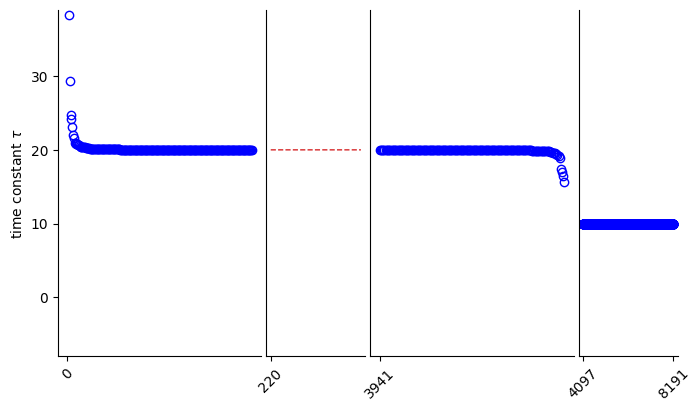

In [13]:
# lambda plot
eigs, _, vl_prime = get_eigspec_pre(num_modes=8192, img=2, nl=0)
timescale = -1 / eigs

vl_prime_norm = np.linalg.norm(vl_prime, axis=0)
eff_dim = np.where(vl_prime_norm == 0)[0][0]
g_dim = np.where(vl_prime_norm == 0)[0][-1] + 1

fig = plt.figure(figsize=(10, 3))
gs = fig.add_gridspec(1, 10, wspace=0.05, hspace=0.05)
ax1 = fig.add_subplot(gs[0, 0:3])
ax2 = fig.add_subplot(gs[0, 3])
ax3 = fig.add_subplot(gs[0, 4:7])
ax4 = fig.add_subplot(gs[0, 7:10])

ax1.plot(np.arange(0, eff_dim), timescale[:eff_dim], 'bo', markerfacecolor='none')
# ax1.set_title('group1')
ax1.set_ylim(-8, 39)
ax1.set_xticks([0], [0])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# ax1.tick_params(axis='x', rotation=45)

ax2.plot(np.arange(eff_dim, g_dim), timescale[eff_dim: g_dim], '--', linewidth=1, color='tab:red')
# ax2.set_title('group2')
ax2.set_ylim(-8, 39)
ax2.set_xticks([eff_dim], [eff_dim])
ax2.set_yticks([], [])
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
# ax2.tick_params(axis='x', rotation=45)

ax3.plot(np.arange(g_dim, 4097), timescale[g_dim: 4097], 'bo', markerfacecolor='none')
# ax3.set_title('group3')
ax3.set_ylim(-8, 39)
ax3.set_xticks([g_dim], [g_dim])
ax3.set_yticks([], [])
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
# ax3.tick_params(axis='x', rotation=45)

ax4.plot(np.arange(4097, 8192), timescale[4097:], 'bo', markerfacecolor='none')
# ax4.plot(8192, timescale[0], 'ro', markerfacecolor='none')
# ax4.set_title('group4')
ax4.set_ylim(-8, 39)
ax4.set_xticks([4097, 8191], [4097, 8191])
ax4.set_yticks([], [])
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
# ax4.tick_params(axis='x', rotation=45)

ax1.set_ylabel(r'time constant $\tau$')
plt.savefig('eigs.png')

In [ ]:
# vl_prime plot
group1s, group3s, group4s = [], [], []
for i in range(num_imgs):
    for l in [0, 1, 2]:
        eigs, _, vl_prime = get_eigspec_pre(num_modes=8192, img=i, nl=l)
        
        vl_prime_norm = np.linalg.norm(vl_prime, axis=0)
        eff_dim = np.where(vl_prime_norm == 0)[0][0]
        g_dim = np.where(vl_prime_norm == 0)[0][-1] + 1
        group1 = vl_prime[:, :eff_dim]
        group3 = vl_prime[:, g_dim:f.N_e]
        group4 = vl_prime[:, f.N_e:]
        
        group1s.append(group1)
        group3s.append(group3)
        group4s.append(group4)

        for e in range(5):
            eigs, _, vl_prime = get_eigspec(num_modes=8192, epoch=e, img=i, nl=l)

            vl_prime_norm = np.linalg.norm(vl_prime, axis=0)
            eff_dim = np.where(vl_prime_norm == 0)[0][0]
            g_dim = np.where(vl_prime_norm == 0)[0][-1] + 1
            group1 = vl_prime[:, :eff_dim]
            group3 = vl_prime[:, g_dim:f.N_e]
            group4 = vl_prime[:, f.N_e:]
            
            group1s.append(group1)
            group3s.append(group3)
            group4s.append(group4)

group1 = np.concatenate(group1s, 1)
group3 = np.concatenate(group3s, 1)
group4 = np.concatenate(group4s, 1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, constrained_layout=True, figsize=(9, 1))
ax1.plot(np.arange(f.N_e), group1.mean(1)[:f.N_e], '-', color='b')
ax1.plot(np.arange(f.N_e, f.N_e+f.N_i), group1.mean(1)[f.N_e:], '-', color='grey')
ax1.set_xticks([], [])
ax1.spines.right.set_visible(False)
ax1.spines.top.set_visible(False)
ax1.spines.bottom.set_visible(False)
ax1.spines.left.set_visible(False)
ax1.axvline(x=f.N_e, linestyle='dashed', linewidth=2, color='k')

ax2.plot(np.arange(f.N_e), group3.mean(1)[:f.N_e], '-', color='b')
ax2.plot(np.arange(f.N_e, f.N_e+f.N_i), group3.mean(1)[f.N_e:], '-', color='grey')
ax2.set_xticks([], [])
ax2.spines.right.set_visible(False)
ax2.spines.top.set_visible(False)
ax2.spines.bottom.set_visible(False)
ax2.spines.left.set_visible(False)
ax2.axvline(x=f.N_e, linestyle='dashed', linewidth=2, color='k')

ax3.plot(np.arange(f.N_e), group4.mean(1)[:f.N_e], '-', color='b')
ax3.plot(np.arange(f.N_e, f.N_e+f.N_i), group4.mean(1)[f.N_e:], '-', color='grey')
ax3.set_xticks([], [])
ax3.spines.right.set_visible(False)
ax3.spines.top.set_visible(False)
ax3.spines.bottom.set_visible(False)
ax3.spines.left.set_visible(False)
ax3.axvline(x=f.N_e, linestyle='dashed', linewidth=2, color='k')

plt.savefig('vl_prime_avg.png')

In [38]:
# timescale training
tau_h = np.zeros((3, 3, 5, 50))  # day, nl, img

for n in range(num_imgs):
    for l in [0, 1, 2]:
        # pre
        eigspec_pre, *_ = get_eigspec_pre(num_modes=1000, img=n, nl=l)
        tau_h[0, l, n] = -1 / eigspec_pre[:50]

        # post
        for i, e in enumerate([0, 4]):
            eigspec, *_ = get_eigspec(num_modes=1000, epoch=e, img=n, nl=l)
            tau_h[i+1, l, n] = -1 / eigspec[:50]

tau_h_mean = tau_h.mean(axis=(1, 2))
tau_h_f = tau_h.reshape(3, -1, 50)
tau_h_sem = sem(tau_h_f, 1)

Text(0, 0.5, 'Time constant $\\tau$')

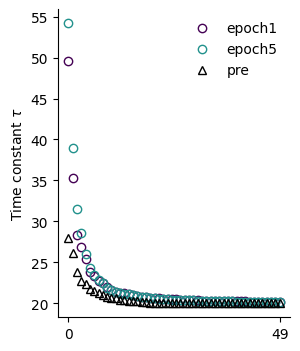

In [16]:
fig, axs = plt.subplots(1, 1, constrained_layout=False, figsize=(3, 4))

dayn = [1, 5]
for i, (tau_mean, tau_sem) in enumerate(zip(tau_h_mean[1:], tau_h_sem[1:])):
    axs.plot(tau_mean, 'o', color=plt.cm.viridis(i/2), label=f'epoch{dayn[i]}', mfc='none')
axs.plot(tau_h_mean[0], '^', color='black', label=f'pre', mfc='none')

axs.legend(frameon=False)

axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.set_xticks([0, 9, 19, 39, 49], [0, 9, 19, 39, 49])
# ax2.set_title(r'$1^{th}$~$40^{th}$')

axs.set_ylabel(r'Time constant $\tau$', fontsize=10)

**Metrics_v2**

In [6]:
def get_normalized_dist(fp):
    '''
    get the normalized distance. fp should be an array of shape (day, noise_level, img, pc), 
    containing all stationary state for every noise level.
    Derivative is estimated as difference between stationary states of 2 adjacent noise level divided by the increment 
    in noise level (10% as a unit). The estimated derivative is normalized by the overall distance scale of the neural space, 
    which is the pooled variance of stationary states of all images at the 2 adjacent noise level. 
    '''
    day, nl, img, _ = fp.shape
    ds = [1, 2, 2]

    euc_dist = np.zeros((day, nl-1, img))
    varr = np.zeros((day, nl-1, img))
    ddc = np.zeros((day, nl-1, img))

    for n in range(img):
        for i in range(nl-1):
            fp_l = fp[:, i, n]  # day, pc
            fp_lp1 = fp[:, i+1, n]

            d = ds[i]
            dist = norm((fp_l - fp_lp1) / d, axis=-1)  # day
            # dist_n = dist / norm(fp_l, axis=-1)
            euc_dist[:, i, n] = dist

            # cov1 = (fp_l - fp_l.mean(1, keepdims=True)).transpose(0, 2, 1) @ (fp_l - fp_l.mean(1, keepdims=True)) / img
            # cov2 = (fp_lp1 - fp_lp1.mean(1, keepdims=True)).transpose(0, 2, 1) @ (fp_lp1 - fp_lp1.mean(1, keepdims=True)) / img
            # var_pooled = np.sqrt(np.trace(0.5 * (cov1 + cov2), axis1=-2, axis2=-1))  # day
            fp_l_alli = fp[:, i]  # day, img, pc
            fp_l_ref = np.expand_dims(fp_l, 1)  # day, 1, pc
            cov1 = (fp_l_alli - fp_l_ref).transpose(0, 2, 1) @ (fp_l_alli - fp_l_ref) / (img - 1)
            var_ = np.sqrt(np.trace(cov1, axis1=-2, axis2=-1))  # day
            # var_n = var_ / norm(fp_l, axis=-1)
            varr[:, i, n] = var_

            dist_norm = dist / var_
            ddc[:, i, n] = dist_norm

    return euc_dist, varr, ddc

all loaded


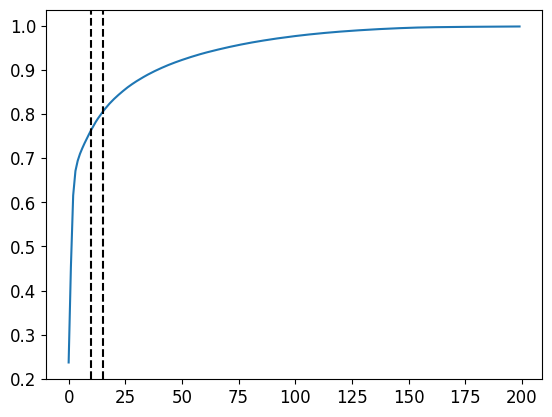

In [7]:
# output, analyzing manifold.
n_pc = 200
ys_pre = np.load('E:/Dataset/Lee/SMT-BCM_response_correct/r_pre_rx1_1000ms_mean_5_4x10_50_64_8_8_mix50%_all.npy')[..., :f.N_e] 
ys_pre = seqUnmix(ys_pre, t_ind, n_ind, n_imgs=num_imgs, npa=10)  # n_img*nl*np, 16, Ne
ys_pre = f.r_numpy(ys_pre)[:, -2:].mean(-2)

ys_all = [ys_pre]
del ys_pre
for i in range(5):
    ys_e = np.load(f'E:/Dataset/Lee/SMT-BCM_response_correct/r_epoch{i}_tx30_rx1_1000ms_mean_5_4x10_50_64_8_8_mix50%_2e9pos1e7_all.npy')[..., :f.N_e]
    ys_e = seqUnmix(ys_e, t_ind, n_ind, n_imgs=num_imgs, npa=10)  # n_img*nl*np, 16, Ne
    ys_e = f.r_numpy(ys_e)[:, -2:].mean(-2)
    ys_all.append(ys_e)
    del ys_e

print('all loaded')

ys_all_exc = np.stack(ys_all)  # (day, n_img*nl*np, Ne)
# ys_all_exc = rearrange(ys_all_exc, 'd (n l p) k -> d n l p k', n=num_imgs, l=4)
# fp_h = ys_all_exc[:, :, :, 0, :].mean(-2)  # day, trial, img, pc

fp_inp = ys_all_exc.reshape(-1, f.N_e)  # (day*n_img*nl*np, f.N_e)
pca = PCA(n_components=n_pc)
fp = pca.fit_transform(fp_inp)
fp = rearrange(fp, '(d n l p) k -> d l n p k', n=num_imgs, l=4, p=10)  # day, noise_level, img, np, pc
fp = fp[:, :, :, 0]  # day, noise_level, img, pc

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axvline(x=10, color='black', linestyle='dashed')
plt.axvline(x=15, color='black', linestyle='dashed')

fp = fp[..., :n_pc]  # take first # pc

euc_dist, varr, ddc = get_normalized_dist(fp)

In [8]:
# load projected stats
out_dir = 'E:/Dataset/Lee/SMT_BCM_proj_stats_v3_slow_nm=1-200_p'

dist_o = np.load(os.path.join(out_dir, 'dist_o.npy'))  # day, nl, img
var_o = np.load(os.path.join(out_dir, 'var_o.npy'))  # day, nl, img
ddc_o = np.load(os.path.join(out_dir, 'ddc_o.npy'))  # day, nl, img
dist_pre_o = np.load(os.path.join(out_dir, 'dist_pre_o.npy'))  # nl, img
var_pre_o = np.load(os.path.join(out_dir, 'var_pre_o.npy')) # nl, img
ddc_pre_o = np.load(os.path.join(out_dir, 'ddc_pre_o.npy')) # nl, img
dist_i = np.load(os.path.join(out_dir, 'dist_i.npy'))  # day, nl, img
var_i = np.load(os.path.join(out_dir, 'var_i.npy'))  # day, nl, img
ddc_i = np.load(os.path.join(out_dir, 'ddc_i.npy'))  # day, nl, img
dist_pre_i = np.load(os.path.join(out_dir, 'dist_pre_i.npy'))  # nl, img
var_pre_i = np.load(os.path.join(out_dir, 'var_pre_i.npy')) # nl, img
ddc_pre_i = np.load(os.path.join(out_dir, 'ddc_pre_i.npy')) # nl, img
dist_ff = np.load(os.path.join(out_dir, 'dist_ff.npy'))  # nl, img
var_ff = np.load(os.path.join(out_dir, 'var_ff.npy'))  # nl, img
ddc_ff = np.load(os.path.join(out_dir, 'ddc_ff.npy'))  # nl, img

#### Plot

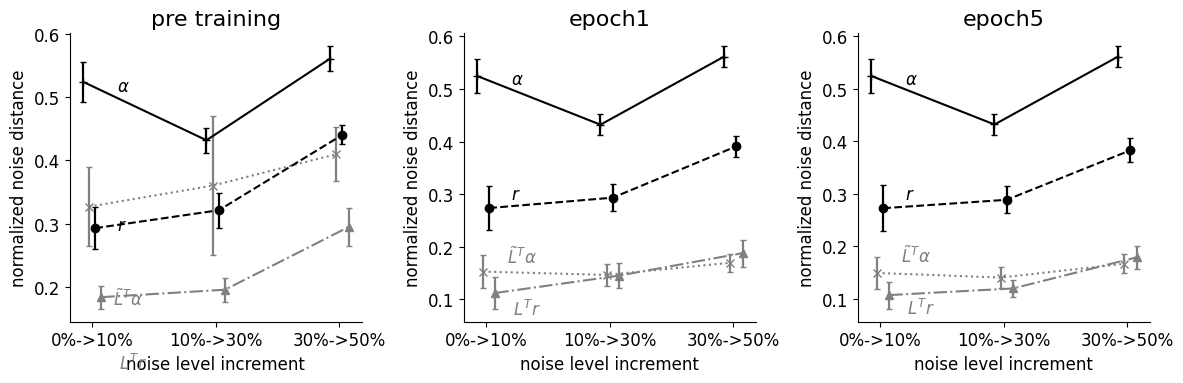

In [24]:
# comparison between four measures -- ddc
nnd = 21
ddc_pre = [ddc_ff, ddc_pre_i[(nnd-1)//4], ddc[0], ddc_pre_o[(nnd-1)//4]]
ddc_e1 = [ddc_ff, ddc_i[(nnd-1)//4, 0], ddc[1], ddc_o[(nnd-1)//4, 0]]
ddc_e5 = [ddc_ff, ddc_i[(nnd-1)//4, -3], ddc[-3], ddc_o[(nnd-1)//4, -3]]
datas = [ddc_pre, ddc_e1, ddc_e5]

fig, axs = plt.subplots(1, 3, tight_layout=True, figsize=(12, 4))
titles = ['pre training', 'epoch1', 'epoch5']
for j, (ax, data) in enumerate(zip(axs, datas)):
    x = np.arange(3)
    ax.set_xticks(np.arange(3), ['0%->10%', '10%->30%', '30%->50%'])
    labels = [r'$\alpha$', r'$\tilde{L}^T \alpha$', r'$r$', r'$L^T r$']
    fmts = ['-+', ':x', '--o', '-.^']
    dodge = [-0.075, -0.025, 0.025, 0.075]
    for i, mat in enumerate(data):  # mat: nl, img
        x_ = x + dodge[i]
        # mat = mat[1:, :]
        mat_mean = mat.mean(-1)  # nl
        # mat_mean = np.median(mat, -1)
        mat_sem = sem(mat, -1)  # nl
        label = labels[i]
        fmt = fmts[i]
        col = 'k' if (i == 0 or i == 2) else 'grey'
        ax.errorbar(x_, mat_mean, yerr=mat_sem, fmt=fmt, label=label,
                     color=col, elinewidth=1.6, capsize=2, )
    ax.set_title(titles[j])
    ax.text(0.2, 0.51, r'$\alpha$')
    ax.text(0.2, 0.29, r'$r$')
    ax.text(0.17, 0.17, r'$\tilde{L}^T \alpha$', c='grey')
    ax.text(0.22, 0.07, r'$L^T r$', c='grey')
    # ax.legend(frameon=False, ncols=2)
    ax.set_xlabel('noise level increment')
    ax.set_ylabel('normalized noise distance')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
# fig.supylabel("normalized |x'|")
# fig.supxlabel('noise level increment')

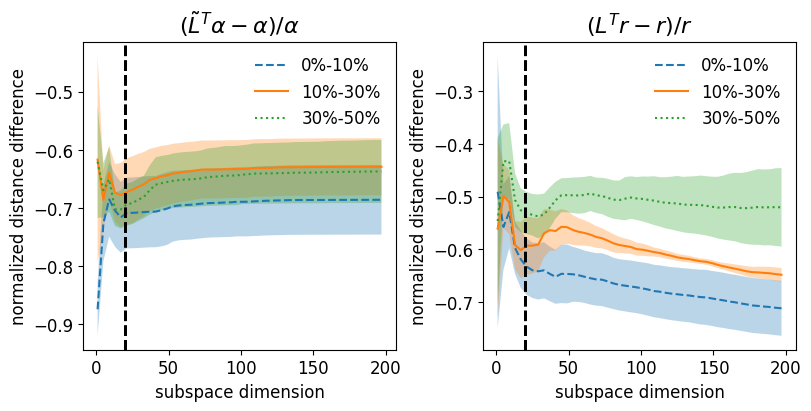

In [25]:
# diff ~ subspace dim
data = [ddc_ff, ddc_i[:, -1], ddc[-1], ddc_o[:, -1]]  # nnd, nl, img

dodge = 0.3
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(8, 4))
x_plot = np.arange(0, 200, 4)+1
for nl in range(3):
    di = (data[1][:, nl] - np.expand_dims(data[0][nl], 0)) / np.expand_dims(data[0][nl], 0)  # nnd, img
    do = (data[3][:, nl] - np.expand_dims(data[2][nl], 0)) / np.expand_dims(data[2][nl], 0)  # nnd, img
    di_mean = di.mean(-1)
    di_sem = sem(di, -1)
    do_mean = do.mean(-1)
    do_sem = sem(do, -1)
    
    # plot
    fmt = ['--', '-', ':']
    labels = ['0%-10%', '10%-30%', '30%-50%']
    ax1.plot(x_plot, di_mean, fmt[nl], label=labels[nl])
    ax1.fill_between(x_plot, di_mean+di_sem, di_mean-di_sem, alpha=.3)
    ax2.plot(x_plot, do_mean, fmt[nl], label=labels[nl])
    ax2.fill_between(x_plot, do_mean+do_sem, do_mean-do_sem, alpha=.3)
    ax1.axvline(x=20, linestyle='dashed', linewidth=2, color='k')
    ax2.axvline(x=20, linestyle='dashed', linewidth=2, color='k')
    ax1.legend(frameon=False, loc='upper right')
    ax2.legend(frameon=False, loc='upper right')
    ax1.set_ylabel(r'normalized distance difference')
    ax1.set_title(r'$(\tilde{L}^T \alpha - \alpha) / \alpha$')
    ax1.set_xlabel('subspace dimension')
    # ax1.set_ylim(-0.93, -0.21)
    ax2.set_ylabel(r'normalized distance difference')
    ax2.set_title(r'$(L^T r - r) / r$')
    ax2.set_xlabel('subspace dimension')
    # ax2.set_ylim(-0.93, -0.21)

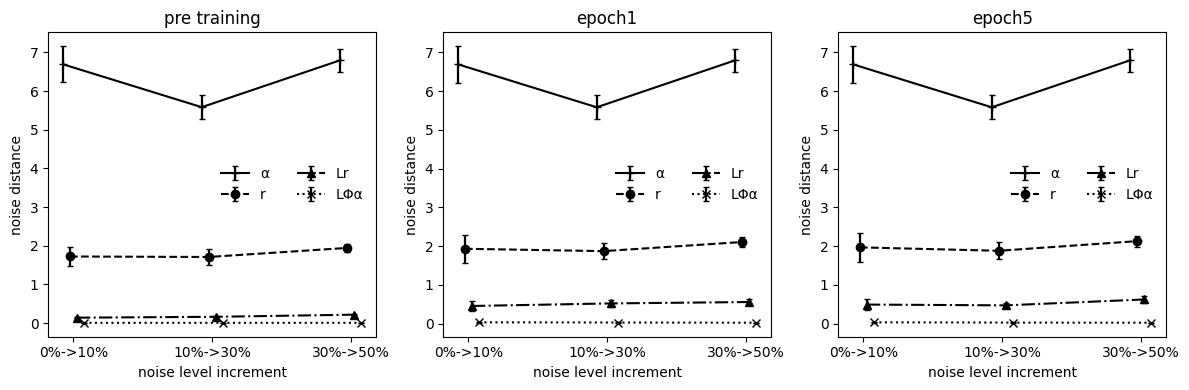

In [44]:
# comparison between four measures -- dist
nnd = 20
# pre = [dist_ff, euc_dist[0], dist_pre_o, dist_pre_i]
# e1 = [dist_ff, euc_dist[1], dist_o[0], dist_i[0]]
# e5 = [dist_ff, euc_dist[-1], dist_o[-1], dist_i[-1]]
pre = [dist_ff, euc_dist[0], dist_pre_o[nnd-1], dist_pre_i[nnd-1]]
e1 = [dist_ff, euc_dist[1], dist_o[nnd-1, 0], dist_i[nnd-1, 0]]
e5 = [dist_ff, euc_dist[-1], dist_o[nnd-1, -1], dist_i[nnd-1, -1]]
datas = [pre, e1, e5]

# fig = plt.figure(constrained_layout=False, figsize=(13, 4))
# gs = fig.add_gridspec(4, 12, hspace=0.06, wspace=1.5, left=0.06)
# # large axes
# axl_1 = fig.add_subplot(gs[0:3, 0:4])
# axl_2 = fig.add_subplot(gs[0:3, 4:8])
# axl_3 = fig.add_subplot(gs[0:3, 8:12])
# axls = [axl_1, axl_2, axl_3]
# # small axes
# axs_1 = fig.add_subplot(gs[3, 0:4])
# axs_2 = fig.add_subplot(gs[3, 4:8])
# axs_3 = fig.add_subplot(gs[3, 8:12])
# axss = [axs_1, axs_2, axs_3]

# titles = ['pre training', 'epoch1', 'epoch5']
# # handles = []
# for j, (axl, axs, data) in enumerate(zip(axls, axss, datas)):
#     x = np.arange(3)
#     labels = ['α', 'r', 'Lr', 'LΦα']
#     fmts = ['-+', '--o', '-.^', ':x']
#     dodge = [-0.075, -0.025, 0.025, 0.075]
#     handles = []
#     for i, mat in enumerate(data):  # mat: nl, img
#         x_ = x  # + dodge[i]
#         # mat = mat[1:]
#         mat_mean = mat.mean(-1)  # nl
#         mat_sem = sem(mat, -1)  # nl
#         label = labels[i]
#         fmt = fmts[i]
#         if i == 3:
#             eb = axs.errorbar(x_, mat_mean, yerr=mat_sem, fmt=fmt, label=label, 
#                                color='black', elinewidth=1.6, capsize=2, )
#             # axs.set_ylim(0, 0.1)
#             # axs.set_yticks([0, 0.05], [0, 0.05])
#             axs.set_xticks(np.arange(3), ['0%->10%', '10%->30%', '30%->50%'])
#             handles.append(eb)
#         else:
#             eb = axl.errorbar(x_, mat_mean, yerr=mat_sem, fmt=fmt, label=label, 
#                               color='black', elinewidth=1.6, capsize=2, )
#             axl.set_xticks([], [])
#             axl.set_yticks([1, 3, 5, 7], [1, 3, 5, 7])
#             # axl.set_ylim(1, 10)
#             handles.append(eb)
    
#     axl.set_title(titles[j])
#     axl.legend(handles=handles, frameon=False)
#     # axs.legend(frameon=False)

#     axl.spines.bottom.set_visible(False)
#     axs.spines.top.set_visible(False)
#     d = .5  # proportion of vertical to horizontal extent of the slanted line
#     kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
#                 linestyle="none", color='k', mec='k', mew=1, clip_on=False)
#     axl.plot([0, 1], [0, 0], transform=axl.transAxes, **kwargs)
#     axs.plot([0, 1], [1, 1], transform=axs.transAxes, **kwargs)

# # fig.legend(handles=handles[:4], frameon=False, loc='lower center', ncols=4)
# fig.supylabel("unnormalized |x'|")
# fig.supxlabel('noise level increment')

fig, axs = plt.subplots(1, 3, tight_layout=True, figsize=(12, 4))
titles = ['pre training', 'epoch1', 'epoch5']
for j, (ax, data) in enumerate(zip(axs, datas)):
    x = np.arange(3)
    ax.set_xticks(np.arange(3), ['0%->10%', '10%->30%', '30%->50%'])
    labels = ['α', 'r', 'Lr', 'LΦα']
    fmts = ['-+', '--o', '-.^', ':x']
    # labels = ['α', 'Lr', 'LΦα']
    # fmts = ['-+', '-.^', ':x']
    dodge = [-0.075, -0.025, 0.025, 0.075]
    for i, mat in enumerate(data):  # mat: nl, img
        x_ = x + dodge[i]
        # mat = mat[1:, :]
        mat_mean = mat.mean(-1)  # nl
        # mat_mean = np.median(mat, -1)
        mat_sem = sem(mat, -1)  # nl
        label = labels[i]
        fmt = fmts[i]
        ax.errorbar(x_, mat_mean, yerr=mat_sem, fmt=fmt, label=label,
                     color='black', elinewidth=1.6, capsize=2, )
    ax.set_title(titles[j])
    ax.legend(frameon=False, ncols=2)
    ax.set_xlabel('noise level increment')
    ax.set_ylabel('noise distance')

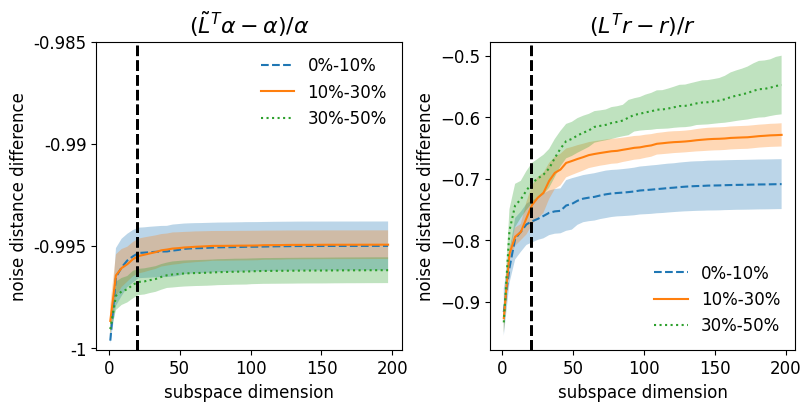

In [29]:
# diff ~ subspace dim
data = [dist_ff, dist_i[:, -1], euc_dist[-1], dist_o[:, -1]]  # nnd, nl, img

dodge = 0.3
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(8, 4))
x_plot = np.arange(0, 200, 4)+1
for nl in range(3):
    di = (data[1][:, nl] - np.expand_dims(data[0][nl], 0)) / np.expand_dims(data[0][nl], 0)  # nnd, img
    do = (data[3][:, nl] - np.expand_dims(data[2][nl], 0)) / np.expand_dims(data[2][nl], 0)  # nnd, img
    di_mean = di.mean(-1)
    di_sem = sem(di, -1)
    do_mean = do.mean(-1)
    do_sem = sem(do, -1)
    
    # plot
    fmt = ['--', '-', ':']
    labels = ['0%-10%', '10%-30%', '30%-50%']
    ax1.plot(x_plot, di_mean, fmt[nl], label=labels[nl])
    ax1.fill_between(x_plot, di_mean+di_sem, di_mean-di_sem, alpha=.3)
    ax1.axvline(x=20, linestyle='dashed', linewidth=2, color='k')
    ax2.plot(x_plot, do_mean, fmt[nl], label=labels[nl])
    ax2.fill_between(x_plot, do_mean+do_sem, do_mean-do_sem, alpha=.3)
    ax2.axvline(x=20, linestyle='dashed', linewidth=2, color='k')
    # ax.axhline(y=0, linestyle='dashed', linewidth=2, color='k')
    ax1.legend(frameon=False, loc='upper right')
    ax2.legend(frameon=False, loc='lower right')
    ax1.set_ylabel(r'noise distance difference')
    ax1.set_title(r'$(\tilde{L}^T \alpha - \alpha) / \alpha$')
    ax1.set_xlabel('subspace dimension')
    # ax1.set_ylim(-1.0, -0.981)
    ax1.set_yticks([-1, -0.995, -0.99, -0.985], [-1, -0.995, -0.99, -0.985])
    ax2.set_ylabel(r'noise distance difference')
    ax2.set_title(r'$(L^T r - r) / r$')
    ax2.set_xlabel('subspace dimension')
    # ax2.set_ylim(-0.95, 0.18)
    # ax2.set_yticks([-1, -0.995, -0.99, -0.985], [-1, -0.995, -0.99, -0.985])

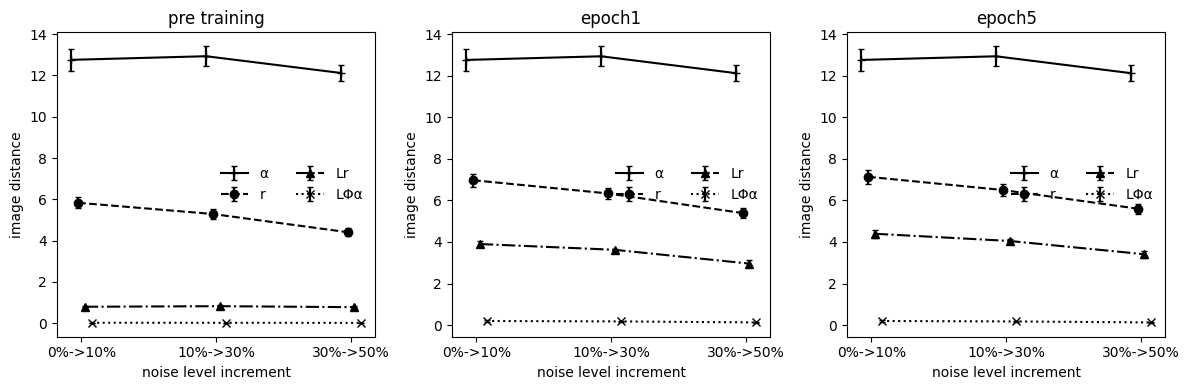

In [45]:
# comparison between four measures -- var
nnd = 20
# pre = [var_ff[:, 0], varr[0], var_pre_o, var_pre_i]
# e1 = [var_ff[:, 0], varr[1], var_o[0], var_i[0]]
# e5 = [var_ff[:, 0], varr[-1], var_o[-1], var_i[-1]]
pre = [var_ff, varr[0], var_pre_o[nnd-1], var_pre_i[nnd-1]]
e1 = [var_ff, varr[1], var_o[nnd-1, 0], var_i[nnd-1, 0]]
e5 = [var_ff, varr[-1], var_o[nnd-1, -1], var_i[nnd-1, -1]]
datas = [pre, e1, e5]

# fig = plt.figure(constrained_layout=False, figsize=(13, 4))
# gs = fig.add_gridspec(4, 12, hspace=0.06, wspace=1.5, left=0.06)
# # large axes
# axl_1 = fig.add_subplot(gs[0:3, 0:4])
# axl_2 = fig.add_subplot(gs[0:3, 4:8])
# axl_3 = fig.add_subplot(gs[0:3, 8:12])
# axls = [axl_1, axl_2, axl_3]
# # small axes
# axs_1 = fig.add_subplot(gs[3, 0:4])
# axs_2 = fig.add_subplot(gs[3, 4:8])
# axs_3 = fig.add_subplot(gs[3, 8:12])
# axss = [axs_1, axs_2, axs_3]

# titles = ['pre training', 'epoch1', 'epoch5']
# for j, (axl, axs, data) in enumerate(zip(axls, axss, datas)):
#     x = np.arange(3)
#     labels = ['α', 'r', 'Lr', 'LΦα']
#     fmts = ['-+', '--o', '-.^', ':x']
#     dodge = [-0.075, -0.025, 0.025, 0.075]
#     for i, mat in enumerate(data):  # mat: nl
#         x_ = x  # + dodge[i]
#         label = labels[i]
#         fmt = fmts[i]
#         # mat = mat[1:]
#         if (i == 0) | (i == 1):
#             axl.plot(x_, mat, fmt, label=label, color='black')
#         else:
#             mat_mean = mat.mean(-1)  # nl
#             mat_sem = sem(mat, -1)  # nl
#             axs.errorbar(x_, mat_mean, yerr=mat_sem, fmt=fmt, label=label,
#                         color='black', elinewidth=1.6, capsize=2, )
#             axs.set_ylim(0, 0.095)
#             axs.set_yticks([0, 0.04, 0.08], [0, 0.04, 0.08])
#             axs.set_xticks(np.arange(3), ['0%|10%', '10%|30%', '30%|50%'])

#             axl.errorbar(x_, mat_mean, yerr=mat_sem, fmt=fmt, label=label, 
#                         color='black', elinewidth=1.6, capsize=2, )
#             axl.set_xticks([], [])
#             axl.set_yticks([2, 4, 6, 8], [2, 4, 6, 8])
#             axl.set_ylim(0.5, 10)
    
#     axl.set_title(titles[j])
#     axl.legend(frameon=False)

#     axl.spines.bottom.set_visible(False)
#     axs.spines.top.set_visible(False)
#     d = .5  # proportion of vertical to horizontal extent of the slanted line
#     kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
#                 linestyle="none", color='k', mec='k', mew=1, clip_on=False)
#     axl.plot([0, 1], [0, 0], transform=axl.transAxes, **kwargs)
#     axs.plot([0, 1], [1, 1], transform=axs.transAxes, **kwargs)

# fig.supylabel("distance scale")
# fig.supxlabel('noise level (pooled)')

fig, axs = plt.subplots(1, 3, tight_layout=True, figsize=(12, 4))
titles = ['pre training', 'epoch1', 'epoch5']
for j, (ax, data) in enumerate(zip(axs, datas)):
    x = np.arange(3)
    ax.set_xticks(np.arange(3), ['0%->10%', '10%->30%', '30%->50%'])
    labels = ['α', 'r', 'Lr', 'LΦα']
    fmts = ['-+', '--o', '-.^', ':x']
    # labels = ['α', 'Lr', 'LΦα']
    # fmts = ['-+', '-.^', ':x']
    dodge = [-0.075, -0.025, 0.025, 0.075]
    for i, mat in enumerate(data):  # mat: nl, img
        x_ = x + dodge[i]
        # mat = mat[1:, :]
        mat_mean = mat.mean(-1)  # nl
        # mat_mean = np.median(mat, -1)
        mat_sem = sem(mat, -1)  # nl
        label = labels[i]
        fmt = fmts[i]
        ax.errorbar(x_, mat_mean, yerr=mat_sem, fmt=fmt, label=label,
                     color='black', elinewidth=1.6, capsize=2, )
    ax.set_title(titles[j])
    ax.legend(frameon=False, ncols=2)
    ax.set_xlabel('noise level increment')
    ax.set_ylabel('image distance')

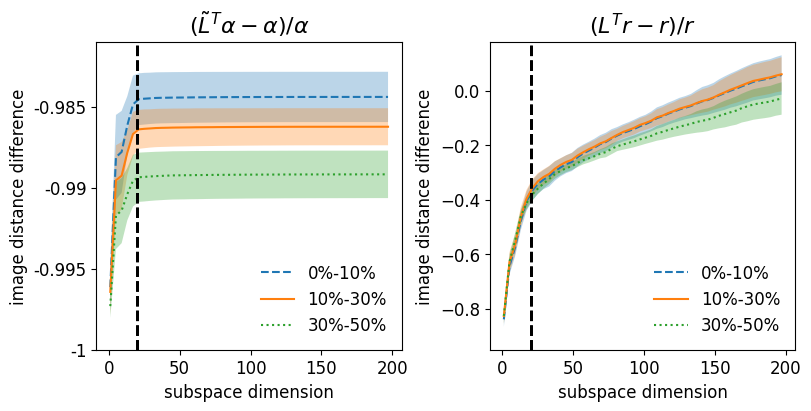

In [33]:
# diff ~ subspace dim
data = [var_ff, var_i[:, -1], varr[-1], var_o[:, -1]]  # nnd, nl, img

dodge = 0.3
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(8, 4))
x_plot = np.arange(0, 200, 4)+1
for nl in range(3):
    di = (data[1][:, nl] - np.expand_dims(data[0][nl], 0)) / np.expand_dims(data[0][nl], 0)  # nnd, img
    do = (data[3][:, nl] - np.expand_dims(data[2][nl], 0)) / np.expand_dims(data[2][nl], 0)  # nnd, img
    di_mean = di.mean(-1)
    di_sem = sem(di, -1)
    do_mean = do.mean(-1)
    do_sem = sem(do, -1)
    
    # plot
    fmt = ['--', '-', ':']
    labels = ['0%-10%', '10%-30%', '30%-50%']
    ax1.plot(x_plot, di_mean, fmt[nl], label=labels[nl])
    ax1.fill_between(x_plot, di_mean+di_sem, di_mean-di_sem, alpha=.3)
    ax1.axvline(x=20, linestyle='dashed', linewidth=2, color='k')
    ax2.plot(x_plot, do_mean, fmt[nl], label=labels[nl])
    ax2.fill_between(x_plot, do_mean+do_sem, do_mean-do_sem, alpha=.3)
    ax2.axvline(x=20, linestyle='dashed', linewidth=2, color='k')
    # ax.axhline(y=0, linestyle='dashed', linewidth=2, color='k')
    ax1.legend(frameon=False, loc='lower right')
    ax2.legend(frameon=False, loc='lower right')
    ax1.set_ylabel(r'image distance difference')
    ax1.set_title(r'$(\tilde{L}^T \alpha - \alpha) / \alpha$')
    ax1.set_xlabel('subspace dimension')
    ax1.set_ylim(-1.0, -0.981)
    ax1.set_yticks([-1, -0.995, -0.99, -0.985], [-1, -0.995, -0.99, -0.985])
    ax2.set_ylabel(r'image distance difference')
    ax2.set_title(r'$(L^T r - r) / r$')
    ax2.set_xlabel('subspace dimension')
    ax2.set_ylim(-0.95, 0.18)

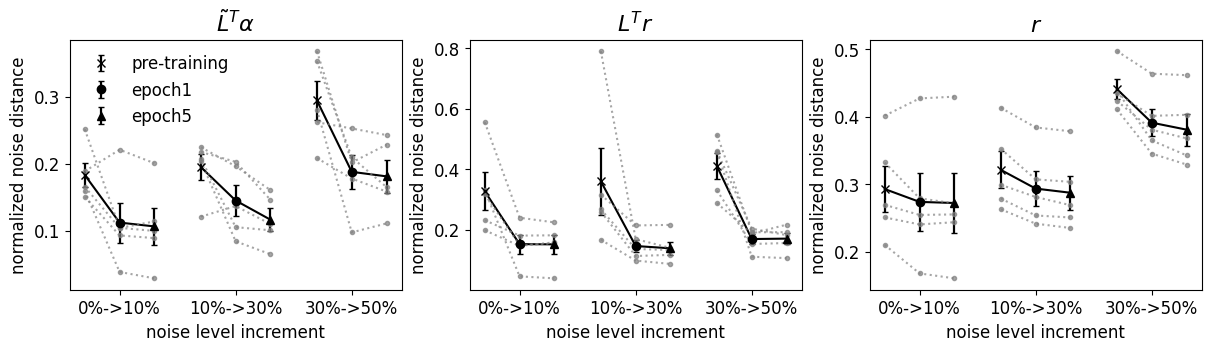

In [36]:
nnd = 21
ddc_all = [[ddc_o[(nnd-1)//4], ddc_pre_o[(nnd-1)//4]], [ddc_i[(nnd-1)//4], ddc_pre_i[(nnd-1)//4]], [ddc[1:], ddc[0]]]
titles = [r'$\tilde{L}^T \alpha$', r'$L^T r$', r'$r$']
# labels = ['10%', '30%', '50%']
# fmts_pre = ['+', 'x', 'o']
# fmts_post = ['-+', '-x', '-o']

dodge = 0.3
fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(12, 3.4))
locs = ['upper left', 'upper right', 'lower right']
for i, (ax, ddc_pair) in enumerate(zip(axs, ddc_all)):
    post, pre = ddc_pair  # day, nl, img; nl, img
    post_mean = post.mean(-1)[:, :]  # day, nl
    post_sem = sem(post, -1)[:, :]  # day, nl
    pre_mean = pre.mean(-1)[:]  # nl
    pre_sem = sem(pre, -1)[:]  # nl

    # # nl as x axis
    x = np.arange(3)
    ax.errorbar(x - dodge, pre_mean, yerr=pre_sem, fmt='x', label='pre-training', 
                color='black', elinewidth=1.6, capsize=2, )
    ax.errorbar(x, post_mean[0], yerr=post_sem[0], fmt='o', label='epoch1', 
                color='black', elinewidth=1.6, capsize=2, )
    ax.errorbar(x + dodge, post_mean[-1], yerr=post_sem[-1], fmt='^', label='epoch5', 
                color='black', elinewidth=1.6, capsize=2, )
    
    for j in range(3):
        x_ = [j-dodge, j, j+dodge]
        y = [pre_mean[j], post_mean[0, j], post_mean[-1, j]]
        ax.plot(x_, y, '-', color='black')
        
        for m in range(5):
            y = [pre[j, m], post[0, j, m], post[-1, j, m]]
            ax.plot(x_, y, ':.', color='gray', alpha=.7)

    # ax.legend(frameon=False)
    ax.set_xticks([0, 1, 2], ['0%->10%', '10%->30%', '30%->50%'])
    if i == 0:
        ax.legend(frameon=False, loc=locs[i])
    ax.set_title(titles[i])
    ax.set_xlabel('noise level increment')
    ax.set_ylabel('normalized noise distance')
    # if i == 1:
    #     ax.set_ylim(0.08, 0.75)

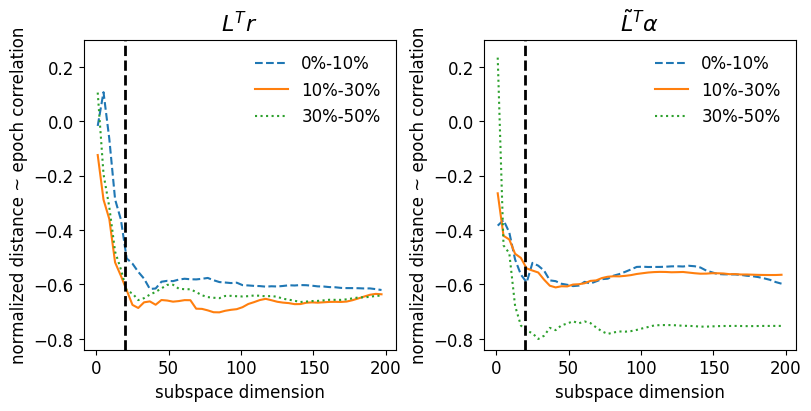

In [39]:
# pearson corr
ddc_all = [[ddc_o, ddc_pre_o], [ddc_i, ddc_pre_i]]

dodge = 0.3
x = np.repeat(np.arange(3), num_imgs)
rng = np.random.default_rng()
# method = stats.BootstrapMethod(method='BCa', random_state=rng)

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(8, 4))
tts = [r'$L^T r$', r'$\tilde{L}^T \alpha$']
for j, (ax, ddc_pair) in enumerate(zip(axs, ddc_all)):
    post, pre = ddc_pair  # day, nl, img; nl, img
    y = np.concatenate([pre, post[:, 0], post[:, -1]], -1) # nn, nl, day*img
    rrs = np.zeros((50, 3))
    # cih = np.zeros((50, 3))
    # cil = np.zeros((50, 3))
    for nnd in range(50):
        for nl in range(3):
            res = pearsonr(x, y[nnd, nl])
            rrs[nnd, nl] = res.statistic
            # cil[nnd, nl], cih[nnd, nl] = res.confidence_interval(confidence_level=0.9, method=method)
            # rrs[nnd, nl] = np.corrcoef(x, y[nnd, nl])[0, 1]
    # plot
    fmt = ['--', '-', ':']
    labels = ['0%-10%', '10%-30%', '30%-50%']
    x_plot = np.arange(0, 200, 4)+1
    for i in range(3):
        ax.plot(x_plot, rrs[:, i], fmt[i], label=labels[i])
        # ax.fill_between(np.arange(0, 50)+1, cil[:, i], cih[:, i], alpha=.5, label=labels[i])
    # ax.axhline(y=0, linestyle='dashed', linewidth=2, color='k')
    ax.axvline(x=20, linestyle='dashed', linewidth=2, color='k')
    ax.legend(frameon=False, loc='upper right')
    ax.set_ylabel(r'normalized distance ~ epoch correlation')
    ax.set_xlabel('subspace dimension')
    ax.set_title(tts[j])
    ax.set_ylim(-0.84, 0.3)

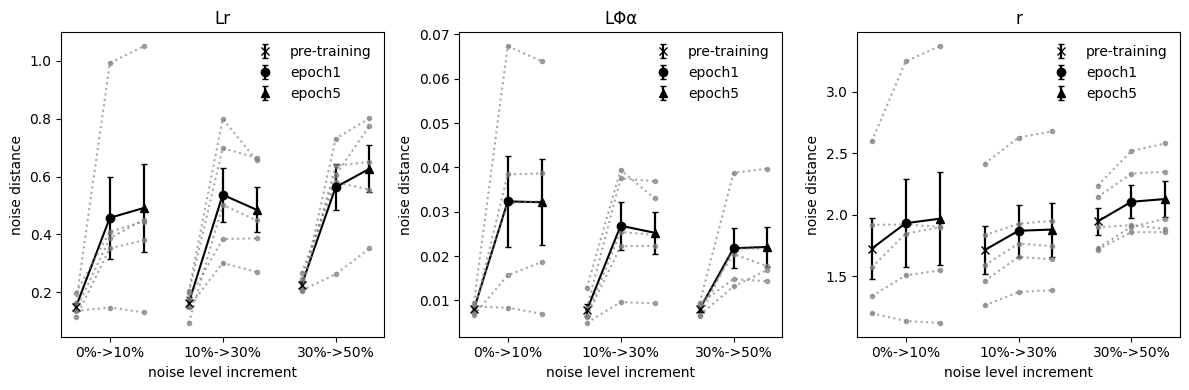

In [16]:
nnd = 21
dist_all = [[dist_o[(nnd-1)//4], dist_pre_o[(nnd-1)//4]], [dist_i[(nnd-1)//4], dist_pre_i[(nnd-1)//4]], [euc_dist[1:], euc_dist[0]]]
titles = ['Lr', 'LΦα', 'r']
# labels = ['10%', '30%', '50%']
# fmts_pre = ['+', 'x', 'o']
# fmts_post = ['-+', '-x', '-o']

dodge = 0.3
fig, axs = plt.subplots(1, 3, tight_layout=True, figsize=(12, 4))
for i, (ax, dist_pair) in enumerate(zip(axs, dist_all)):
    post, pre = dist_pair  # day, nl, img; nl, img
    post_mean = post.mean(-1)[:, :]  # day, nl
    post_sem = sem(post, -1)[:, :]  # day, nl
    pre_mean = pre.mean(-1)[:]  # nl
    pre_sem = sem(pre, -1)[:]  # nl

    # # nl as x axis
    x = np.arange(3)
    ax.errorbar(x - dodge, pre_mean, yerr=pre_sem, fmt='x', label='pre-training', 
                color='black', elinewidth=1.6, capsize=2, )
    ax.errorbar(x, post_mean[0], yerr=post_sem[0], fmt='o', label='epoch1', 
                color='black', elinewidth=1.6, capsize=2, )
    ax.errorbar(x + dodge, post_mean[-1], yerr=post_sem[-1], fmt='^', label='epoch5', 
                color='black', elinewidth=1.6, capsize=2, )
    
    for j in range(3):
        x_ = [j-dodge, j, j+dodge]
        y = [pre_mean[j], post_mean[0, j], post_mean[-1, j]]
        ax.plot(x_, y, '-', color='black')
        
        for m in range(5):
            y = [pre[j, m], post[0, j, m], post[-1, j, m]]
            ax.plot(x_, y, ':.', color='gray', alpha=.7)

    # ax.legend(frameon=False)
    ax.set_xticks([0, 1, 2], ['0%->10%', '10%->30%', '30%->50%'])
    ax.legend(frameon=False, loc='upper right')
    ax.set_title(titles[i])
    ax.set_xlabel('noise level increment')
    ax.set_ylabel('noise distance')
    # if i == 0:
    #     ax.set_ylim(0.13, 1.6)
    # if i == 1:
    #     ax.set_ylim(0.09, 0.83)

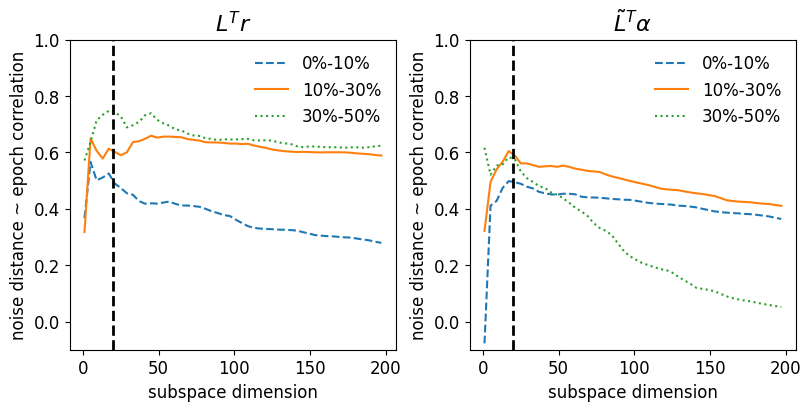

In [40]:
# pearson corr
dist_all = [[dist_o, dist_pre_o], [dist_i, dist_pre_i]]

dodge = 0.3
x = np.repeat(np.arange(3), num_imgs)
# rng = np.random.default_rng()
# method = PermutationMethod(n_resamples=np.inf, random_state=rng)

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(8, 4))
tts = [r'$L^T r$', r'$\tilde{L}^T \alpha$']
for j, (ax, dist_pair) in enumerate(zip(axs, dist_all)):
    post, pre = dist_pair  # day, nl, img; nl, img
    y = np.concatenate([pre, post[:, 0], post[:, -1]], -1) # nn, nl, day*img
    rrs = np.zeros((50, 3))
    for nnd in range(50):
        for nl in range(3):
            res = pearsonr(x, y[nnd, nl])
            rrs[nnd, nl] = res.statistic
    # plot
    fmt = ['--', '-', ':']
    labels = ['0%-10%', '10%-30%', '30%-50%']
    x_plot = np.arange(0, 200, 4)+1
    for i in range(3):
        ax.plot(x_plot, rrs[:, i], fmt[i], label=labels[i])
    # ax.axhline(y=0, linestyle='dashed', linewidth=2, color='k')
    ax.axvline(x=20, linestyle='dashed', linewidth=2, color='k')
    ax.legend(frameon=False, loc='upper right')
    ax.set_ylabel(r'noise distance ~ epoch correlation')
    ax.set_xlabel('subspace dimension')
    ax.set_title(tts[j])
    ax.set_ylim(-0.1, 1)

In [15]:
len(list(range(0, 200, 4)))

50

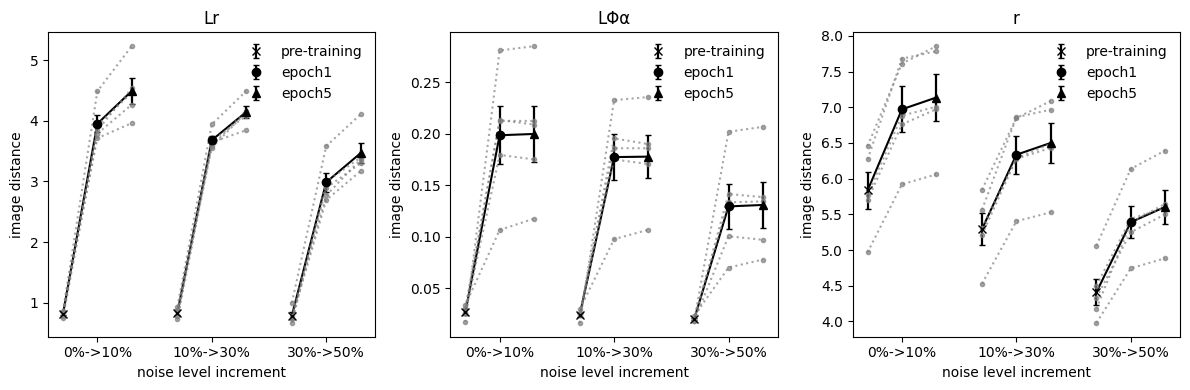

In [15]:
nnd = 21
var_all = [[var_o[(nnd-1)//4], var_pre_o[(nnd-1)//4]], [var_i[(nnd-1)//4], var_pre_i[(nnd-1)//4]], [varr[1:], varr[0]]]
titles = ['Lr', 'LΦα', 'r']
# labels = ['10%', '30%', '50%']
# fmts_pre = ['+', 'x', 'o']
# fmts_post = ['-+', '-x', '-o']

dodge = 0.3
fig, axs = plt.subplots(1, 3, tight_layout=True, figsize=(12, 4))
plt.subplots_adjust(hspace=10)
for i, (ax, var_pair) in enumerate(zip(axs, var_all)):
    post, pre = var_pair  # day, nl, img; nl, img
    post_mean = post.mean(-1)[:, :]  # day, nl
    post_sem = sem(post, -1)[:, :]  # day, nl
    pre_mean = pre.mean(-1)[:]  # nl
    pre_sem = sem(pre, -1)[:]  # nl

    # # nl as x axis
    x = np.arange(3)
    ax.errorbar(x - dodge, pre_mean, yerr=pre_sem, fmt='x', label='pre-training', 
                color='black', elinewidth=1.6, capsize=2, )
    ax.errorbar(x, post_mean[0], yerr=post_sem[0], fmt='o', label='epoch1', 
                color='black', elinewidth=1.6, capsize=2, )
    ax.errorbar(x + dodge, post_mean[-1], yerr=post_sem[-1], fmt='^', label='epoch5', 
                color='black', elinewidth=1.6, capsize=2, )
    
    for j in range(3):
        x_ = [j-dodge, j, j+dodge]
        y = [pre_mean[j], post_mean[0, j], post_mean[-1, j]]
        ax.plot(x_, y, '-', color='black')
        
        for m in range(5):
            y = [pre[j, m], post[0, j, m], post[-1, j, m]]
            ax.plot(x_, y, ':.', color='gray', alpha=.7)

    # ax.legend(frameon=False)
    ax.set_xticks([0, 1, 2], ['0%->10%', '10%->30%', '30%->50%'])
    ax.legend(frameon=False, loc='upper right')
    ax.set_title(titles[i])
    ax.set_xlabel('noise level increment')
    ax.set_ylabel('image distance')
    # if i == 0:
    #     ax.set_ylim(0.13, 1.6)
    # if i == 1:
    #     ax.set_ylim(0.09, 0.83)

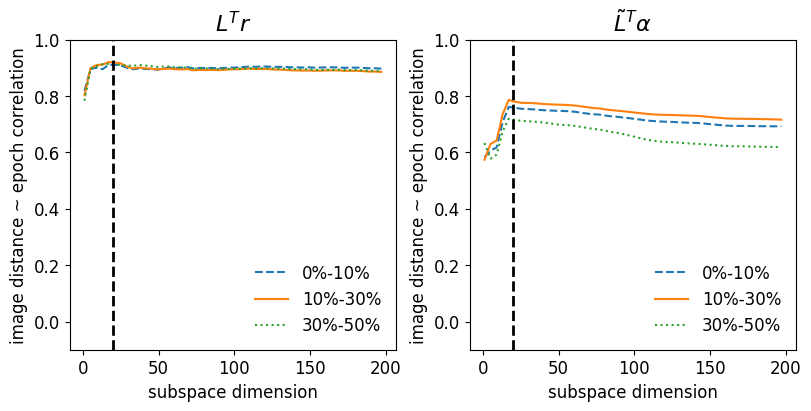

In [42]:
# pearson corr
var_all = [[var_o, var_pre_o], [var_i, var_pre_i]]

dodge = 0.3
x = np.repeat(np.arange(3), num_imgs)
# rng = np.random.default_rng()
# method = PermutationMethod(n_resamples=np.inf, random_state=rng)

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(8, 4))
tts = [r'$L^T r$', r'$\tilde{L}^T \alpha$']
for j, (ax, var_pair) in enumerate(zip(axs, var_all)):
    post, pre = var_pair  # day, nl, img; nl, img
    y = np.concatenate([pre, post[:, 0], post[:, -1]], -1) # nn, nl, day*img
    rrs = np.zeros((50, 3))
    for nnd in range(50):
        for nl in range(3):
            res = pearsonr(x, y[nnd, nl])
            rrs[nnd, nl] = res.statistic
    # plot
    fmt = ['--', '-', ':']
    labels = ['0%-10%', '10%-30%', '30%-50%']
    x_plot = np.arange(0, 200, 4)+1
    for i in range(3):
        ax.plot(x_plot, rrs[:, i], fmt[i], label=labels[i])
    # ax.axhline(y=0, linestyle='dashed', linewidth=2, color='k')
    ax.axvline(x=20, linestyle='dashed', linewidth=2, color='k')
    ax.legend(frameon=False, loc='lower right')
    ax.set_ylabel(r'image distance ~ epoch correlation')
    ax.set_xlabel('subspace dimension')
    ax.set_title(tts[j])
    ax.set_ylim(-0.1, 1)